In [137]:
%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim
import torch.nn as nn
from torch.backends import cudnn

from statistics import mean

import sys
sys.path.append('../data/cifar100/')  
from cifar100_loader import load_cifar100
from models.model import LeNet5 #import the model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hyperparameters

In [138]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Check whether a GPU is available and if so, use it
print(DEVICE)
BATCH_SIZE = 64    # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 4e-4  # Weight decay set as specified in the reference paper [Hsu et al., Federated Visual Classification with Real-World Data Distribution, ECCV 2020]

NUM_EPOCHS = 100      # Total number of training epochs (iterations over dataset)
T_MAX = 100           # The maximum number of epochs before restarting the learning rate scheduler
ETA_MIN = 1e-5        # The minimum learning rate that can be reached by the lr scheduler


cuda


In [139]:
#25% of the dataset kept for validation
trainloader, validloader, testloader = load_cifar100(batch_size=32, validation_split=0.25)

Files already downloaded and verified
Files already downloaded and verified


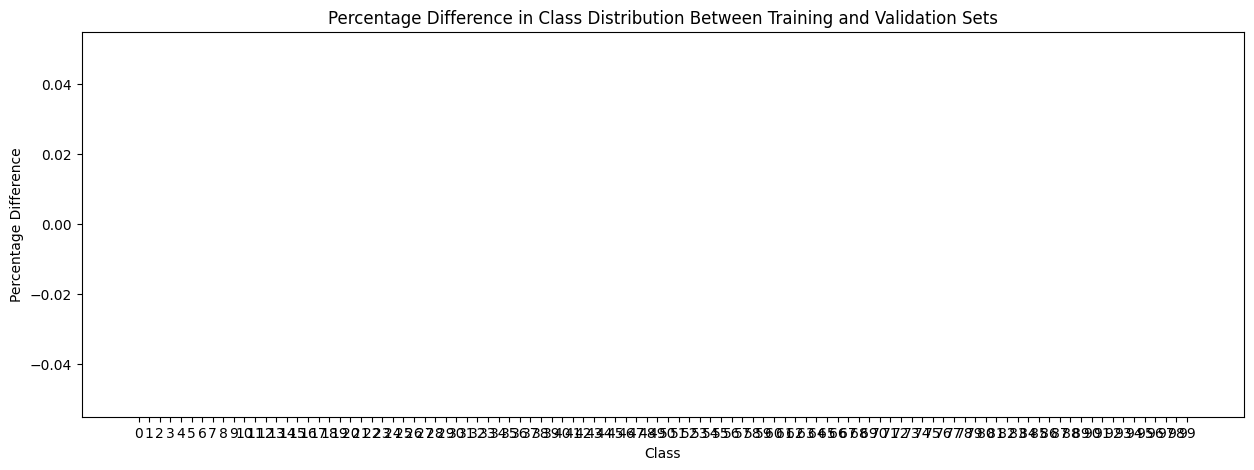

In [140]:
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Subset

def analyze_class_distribution(train_dataset, validation_dataset):
    if isinstance(train_dataset, Subset) and isinstance(validation_dataset, Subset):
        training_labels = [train_dataset.dataset.targets[i] for i in train_dataset.indices]
        validation_labels = [validation_dataset.dataset.targets[i] for i in validation_dataset.indices]
    else:
        training_labels = train_dataset.targets
        validation_labels = validation_dataset.targets

    training_label_count = Counter(training_labels)
    validation_label_count = Counter(validation_labels)
    total_training_labels = sum(training_label_count.values())
    total_validation_labels = sum(validation_label_count.values())

    classes = sorted(training_label_count.keys())
    training_counts = [training_label_count.get(key, 0) for key in classes]
    training_percentages = [count / total_training_labels * 100 for count in training_counts]

    validation_counts = [validation_label_count.get(key, 0) for key in classes]
    validation_percentages = [count / total_validation_labels * 100 for count in validation_counts]

    differences = [abs(tp - vp) / max(tp, vp) * 100 if max(tp, vp) > 0 else 0 for tp, vp in zip(training_percentages, validation_percentages)]

    plt.figure(figsize=(15, 5))
    plt.bar([str(cls) for cls in classes], differences, color='blue')
    plt.xlabel('Class')
    plt.ylabel('Percentage Difference')
    plt.title('Percentage Difference in Class Distribution Between Training and Validation Sets')
    plt.show()

# Supponendo di avere i loader già definiti e configurati:
analyze_class_distribution(trainloader.dataset, validloader.dataset)


# Prepare training

In [141]:
model = LeNet5().to(DEVICE) # Create the model
# Define loss function -> softmax used by the model
criterion = nn.NLLLoss()

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=ETA_MIN, last_epoch=-1)

# Validation

In [142]:
def evaluate(model, dataloader):
    with torch.no_grad():
        model.train(False) # Set Network to evaluation mode
        running_corrects = 0
        losses = []
        for data, targets in dataloader:
            data = data.to(DEVICE)        # Move the data to the GPU
            targets = targets.to(DEVICE)  # Move the targets to the GPU
            # Forward Pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            losses.append(loss.item())
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            # Update Corrects
            running_corrects += torch.sum(preds == targets.data).data.item()
            # Calculate Accuracy
            accuracy = running_corrects / float(len(dataloader.dataset))

    return accuracy, mean(losses)

In [ ]:
val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []
cudnn.benchmark # Calling this optimizes runtime

# Training loop
for epoch in range(NUM_EPOCHS): 
    for data, targets in trainloader:
        data = data.to(DEVICE)        # Move the data to the GPU
        targets = targets.to(DEVICE)  # Move the targets to the GPU
        model.train()                # Set Network to train mode
        optimizer.zero_grad()         # Zero the gradients
        outputs = model(data)         # Pass data through the model
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()               # Backpropagation
        optimizer.step()              # Update model parameters
    train_acc, train_loss = evaluate(model, trainloader)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)

    val_acc, val_loss = evaluate(model, validloader)
    print('Epoch {}, Acc {}'.format(epoch+1, val_acc*100))

    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    # Step the scheduler
    scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Acc 14.328
Epoch 1, Loss: 3.6312601566314697
Epoch 2, Acc 20.52
Epoch 2, Loss: 3.7022290229797363


# Test

In [ ]:
accuracy = evaluate(model, testloader)[0]
print('\nTest Accuracy: {}'.format(accuracy))